In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import tqdm
from scipy.stats import spearmanr
import datetime as dt
import cartopy.crs as ccrs
from merge_data_barpa import load_stn_info
import xarray as xr
import timezonefinder
import pytz

def resample(x,y,f,N):
    
    x_resamp = [np.percentile(x[np.random.randint(0,len(x),len(x))],f) for N in np.arange(N)]
    y_resamp = [np.percentile(y[np.random.randint(0,len(y),len(y))],f) for N in np.arange(N)]
    
    return [ [np.percentile(np.stack(x_resamp),2.5,axis=0), np.percentile(np.stack(x_resamp),97.5,axis=0)],
            [np.percentile(np.stack(y_resamp),2.5,axis=0), np.percentile(np.stack(y_resamp),97.5,axis=0)]]

In [2]:
#Read daily maximum wind gusts at each station, created by resample_daily_max.py

dmax_2p2km_all = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_2p2km.csv")
dmax_2p2km_interp_all = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_2p2km_barpa_r_interp.csv")
dmax_12km_all = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_12km.csv")
dmax_obs_all = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_obs.csv")
dmax_bdsd_all = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_bdsd.csv")
dmax_erai_all = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_erai.csv")

#Calculate another ratio, the gust to deep-layer mean
dmax_2p2km_all["dlm_ratio"] = dmax_2p2km_all["wg10_2p2km_point"] / dmax_2p2km_all["Umean06"]
dmax_12km_all["dlm_ratio"] = dmax_12km_all["wg10_12km_point"] / dmax_12km_all["Umean06"]
dmax_obs_all["dlm_ratio"] = dmax_obs_all["gust"] / dmax_obs_all["Umean06_era5"]

dmax_2p2km_all = dmax_2p2km_all.set_index(pd.to_datetime(dmax_2p2km_all.time))
dmax_2p2km_interp_all = dmax_2p2km_interp_all.set_index(pd.to_datetime(dmax_2p2km_interp_all.time))
dmax_12km_all = dmax_12km_all.set_index(pd.to_datetime(dmax_12km_all.time))
dmax_obs_all = dmax_obs_all.set_index(pd.to_datetime(dmax_obs_all.time))
dmax_bdsd_all = dmax_bdsd_all.set_index(pd.to_datetime(dmax_bdsd_all.time))

In [3]:
#Suspect gusts to drop - observations
obs_times = pd.to_datetime(dmax_obs_all.time)
drop_inds = ((obs_times.dt.month == 12) & (obs_times.dt.year == 2010) & (dmax_obs_all.stn_id==55325) & (dmax_obs_all.gust >= 25)) | (dmax_obs_all.gust>=129)

dmax_2p2km_all = dmax_2p2km_all.loc[~drop_inds.values]
dmax_2p2km_interp_all = dmax_2p2km_interp_all.loc[~drop_inds.values]
dmax_12km_all = dmax_12km_all.loc[~drop_inds.values]
dmax_obs_all = dmax_obs_all.loc[~drop_inds.values]
dmax_erai_all = dmax_erai_all.loc[~drop_inds.values]

In [4]:
print("Number of stations: ",dmax_obs_all.stn_id.unique().shape[0])

Number of stations:  272


In [5]:
#Restrict to lightning-associated gusts
dmax_2p2km_lightning = dmax_2p2km_all.query("n_lightning_fl>=1")
dmax_2p2km_interp_lightning = dmax_2p2km_interp_all.query("n_lightning_fl>=1")
dmax_12km_lightning = dmax_12km_all.query("n_lightning_fl>=1")
dmax_obs_lightning = dmax_obs_all.query("Lightning_observed_daily>=1")

#And non lightning-associated gusts
dmax_2p2km_nonlightning = dmax_2p2km_all.query("n_lightning_fl==0")
dmax_2p2km_interp_nonlightning = dmax_2p2km_interp_all.query("n_lightning_fl==0")
dmax_12km_nonlightning = dmax_12km_all.query("n_lightning_fl==0")
dmax_obs_nonlightning = dmax_obs_all.query("Lightning_observed_daily==0")


In [6]:
#Restrict to convective gusts using a wind gust ratio threshold of 1.5
dmax_2p2km_conv = dmax_2p2km_all.query("wgr_2p2km_point>=1.5")
dmax_12km_conv = dmax_12km_all.query("wgr_12km_point>=1.5")
dmax_obs_conv = dmax_obs_all.query("wgr_4>=1.5").dropna(subset=["gust"])

#And non-convective gusts
dmax_2p2km_nonconv = dmax_2p2km_all.query("wgr_2p2km_point<1.5")
dmax_12km_nonconv = dmax_12km_all.query("wgr_12km_point<1.5")
dmax_obs_nonconv = dmax_obs_all.query("wgr_4<1.5").dropna(subset=["gust"])


Plotting QQ plot for BARPAC-M...
BARPAC-M Interpolated...
BARPA-R
ERA-Interim


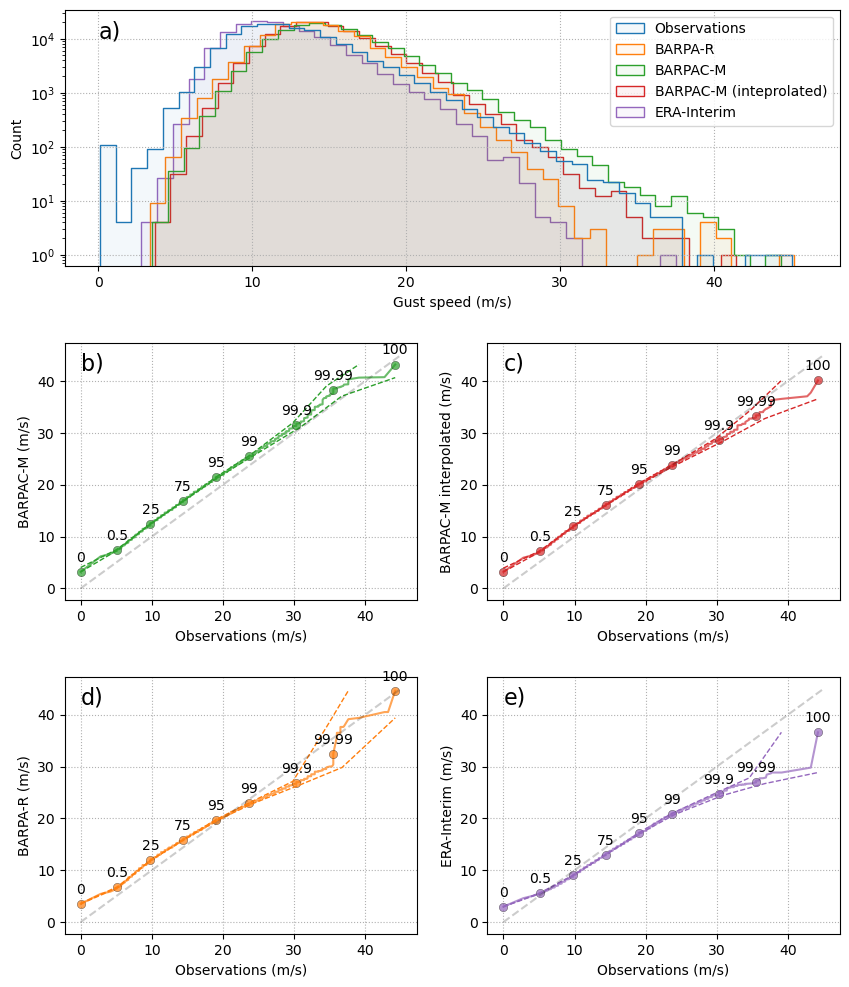

In [44]:
#Plot histogram and qq-plots of daily max gust distributions
#Label a selection of percentiles on the plot
#For those percentiles, include 95% confidence intervals by resampling each model time distribution and comparing the percentiles with observations
#Lines on qq plots use 1000 evenly spaced percentiles up to the 95th observed percentile, then the number of percentiles plotted is equal to 5% of the number of samples (7,280).

plt.figure(figsize=[10,12])

plt.subplot2grid((3,2),(0,0),1,2)

values_2p2km = dmax_2p2km_all["wg10_2p2km_point"].values
values_2p2km_interp = dmax_2p2km_interp_all["wg10_2p2km_point"].values
values_12km = dmax_12km_all["wg10_12km_point"].values
values_obs = dmax_obs_all["gust"].values
values_erai = dmax_erai_all["erai_wg10"].values
temp_df = pd.DataFrame({"Observations":values_obs, "BARPA-R":values_12km, "BARPAC-M":values_2p2km, "BARPAC-M (inteprolated)":values_2p2km_interp, "ERA-Interim":values_erai})

colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple"]
hist = sns.histplot(data=temp_df, bins=np.linspace(0,46,46),
             log_scale=[False,True], multiple="dodge", shrink=0.8, stat="count",common_norm=False,
             element="step",alpha=0.05,legend=True,palette="tab10")

plt.gca().grid(ls=":")
plt.xlabel("Gust speed (m/s)")
#plt.title("Daily-domain maximum wind gust histograms")
plt.text(0,1e4,"a)",size=16);


plt.subplot2grid((3,2),(1,0),1,1)
print("Plotting QQ plot for BARPAC-M...")
p = 1000; p2 = int(values_obs.shape[0] * 0.05)
quants = np.array(list(np.linspace(0,95,p)) + list(np.linspace(95,100,p2)))
quant_labels = [0,0.5,25,75,95,99,99.9,99.99,100]#p=values_obs.shape[0]
N=1000

plt.plot(np.percentile(values_obs,quants),np.percentile(values_2p2km,quants),ls="-",marker="none",mec="k",mew=0.3,alpha=0.7,color="tab:green")
plt.plot(np.percentile(values_obs,quant_labels),np.percentile(values_2p2km,quant_labels),ls="none",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:green")
[plt.text(np.percentile(values_obs,q),np.percentile(values_2p2km,q)+2,str(q),ha="center") for q in quant_labels]

#mod_resamp = [np.percentile(values_2p2km[np.random.randint(0,len(values_2p2km),len(values_2p2km))],quant_labels) for N in np.arange(N)]
#plt.fill_between(np.percentile(values_obs,quant_labels),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:green",alpha=0.3)
obs_resamp, mod_resamp = resample(values_obs, values_2p2km, quant_labels, N)
plt.plot(obs_resamp[0],mod_resamp[1], color="tab:green",alpha=1, ls="--", lw=1)
plt.plot(obs_resamp[1],mod_resamp[0], color="tab:green",alpha=1, ls="--", lw=1)

plt.plot([0,45],[0,45],color="k",ls="--",alpha=0.2)
plt.gca().grid(ls=":")
plt.ylabel("BARPAC-M (m/s)")
plt.xlabel("Observations (m/s)")
plt.text(0,42,"b)",size=16)

plt.subplot2grid((3,2),(1,1),1,1)
print("BARPAC-M Interpolated...")
plt.plot(np.percentile(values_obs,quants),np.percentile(values_2p2km_interp,quants),ls="-",marker="none",mec="k",mew=0.3,alpha=0.7,color="tab:red")
plt.plot(np.percentile(values_obs,quant_labels),np.percentile(values_2p2km_interp,quant_labels),ls="none",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:red")
[plt.text(np.percentile(values_obs,q),np.percentile(values_2p2km_interp,q)+2,str(q),ha="center") for q in quant_labels]
# mod_resamp = [np.percentile(values_2p2km_interp[np.random.randint(0,len(values_2p2km_interp),len(values_2p2km_interp))],quant_labels) for N in np.arange(N)]
# plt.fill_between(np.percentile(values_obs,quant_labels),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:red",alpha=0.3)
obs_resamp, mod_resamp = resample(values_obs, values_2p2km_interp, quant_labels, N)
plt.plot(obs_resamp[0],mod_resamp[1], color="tab:red",alpha=1, ls="--", lw=1)
plt.plot(obs_resamp[1],mod_resamp[0], color="tab:red",alpha=1, ls="--", lw=1)
plt.plot([0,45],[0,45],color="k",ls="--",alpha=0.2)
plt.gca().grid(ls=":")
plt.ylabel("BARPAC-M interpolated (m/s)")
plt.xlabel("Observations (m/s)")
plt.text(0,42,"c)",size=16)

plt.subplot2grid((3,2),(2,0),1,1)
print("BARPA-R")
plt.plot(np.percentile(values_obs,quants),np.percentile(values_12km,quants),ls="-",marker="none",mec="k",mew=0.3,alpha=0.7,color="tab:orange")
plt.plot(np.percentile(values_obs,quant_labels),np.percentile(values_12km,quant_labels),ls="none",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:orange")
[plt.text(np.percentile(values_obs,q),np.percentile(values_12km,q)+2,str(q),ha="center") for q in quant_labels]
# mod_resamp = [np.percentile(values_12km[np.random.randint(0,len(values_12km),len(values_12km))],quant_labels) for N in np.arange(N)]
# plt.fill_between(np.percentile(values_obs,quant_labels),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:orange",alpha=0.3)
obs_resamp, mod_resamp = resample(values_obs, values_12km, quant_labels, N)
plt.plot(obs_resamp[0],mod_resamp[1], color="tab:orange",alpha=1, ls="--", lw=1)
plt.plot(obs_resamp[1],mod_resamp[0], color="tab:orange",alpha=1, ls="--", lw=1)
plt.plot([0,45],[0,45],color="k",ls="--",alpha=0.2)
plt.gca().grid(ls=":")
plt.ylabel("BARPA-R (m/s)")
plt.xlabel("Observations (m/s)")
plt.text(0,42,"d)",size=16)

plt.subplot2grid((3,2),(2,1),1,1)
print("ERA-Interim")
plt.plot(np.percentile(values_obs,quants),np.percentile(values_erai,quants),ls="-",marker="none",mec="k",mew=0.3,alpha=0.7,color="tab:purple")
plt.plot(np.percentile(values_obs,quant_labels),np.percentile(values_erai,quant_labels),ls="none",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:purple")
[plt.text(np.percentile(values_obs,q),np.percentile(values_erai,q)+2,str(q),ha="center") for q in quant_labels]
# mod_resamp = [np.percentile(values_erai[np.random.randint(0,len(values_erai),len(values_erai))],quant_labels) for N in np.arange(N)]
# plt.fill_between(np.percentile(values_obs,quant_labels),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:purple",alpha=0.3)
obs_resamp, mod_resamp = resample(values_obs, values_erai, quant_labels, N)
plt.plot(obs_resamp[0],mod_resamp[1], color="tab:purple",alpha=1, ls="--", lw=1)
plt.plot(obs_resamp[1],mod_resamp[0], color="tab:purple",alpha=1, ls="--", lw=1)
plt.plot([0,45],[0,45],color="k",ls="--",alpha=0.2)
plt.gca().grid(ls=":")
plt.ylabel("ERA-Interim (m/s)")
plt.xlabel("Observations (m/s)")
plt.text(0,42,"e)",size=16)

plt.subplots_adjust(hspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/hist2.jpeg",dpi=400,bbox_inches="tight")

In [8]:
#The agreement between BARPA-R and Obs for the maximum gust is due to a simulated ECL event that occurs over one day.

dmax_12km_all.sort_values("wg10_12km_point",ascending=False).iloc[0:20][["stn_id","wg10_12km_point","state"]]

,stn_id,wg10_12km_point,state
time,,,
2010-02-01 08:10:00,66208,44.625,nsw
2010-02-01 07:50:00,67117,40.500,nsw
2010-02-01 07:50:00,66137,40.500,nsw
2010-02-01 09:00:00,68257,39.375,nsw
2010-02-01 07:30:00,66037,39.125,nsw
2010-02-01 07:30:00,66051,39.125,nsw
2010-02-01 07:30:00,66043,39.125,nsw
2010-02-01 08:00:00,67108,37.750,nsw
2010-02-01 11:20:00,68228,37.625,nsw


In [9]:
#Compute some stats: For a selection of percentiles, compute the bias from each model

values_2p2km = dmax_2p2km_all["wg10_2p2km_point"].values
values_2p2km_interp = dmax_2p2km_interp_all["wg10_2p2km_point"].values
values_12km = dmax_12km_all["wg10_12km_point"].values
values_obs = dmax_obs_all["gust"].dropna().values
values_erai = dmax_erai_all["erai_wg10"].values

temp_df = pd.DataFrame({"Observations (m/s)":values_obs, "BARPA-R (bias, m/s)":values_12km, "BARPAC-M (bias, m/s)":values_2p2km, "BARPAC-M inteprolated (bias, m/s)":values_2p2km_interp, "ERA-Interim (bias, m/s)":values_erai})

#Calculate biases (wind gust speeds) for percentiles specified by p. Also calculate lower and upper CI by resampling the model time series and compare percentiles against the observed percentiles 
stats = pd.DataFrame()
upper = pd.DataFrame()
lower = pd.DataFrame()
p = [0,0.5,25,75,95,99,99.9,99.99,100]

t = 1000; t2 = int(values_obs.shape[0] * 0.05)
quants = np.linspace(95,100,t2)
for c in temp_df.columns:
    print(c)
    if c == "Observations (m/s)":
        stats = pd.concat([stats,pd.DataFrame({c:np.percentile(temp_df[c],p)},index=[str(s)+"th percentile" for s in p])],axis=1)
        lower = pd.concat([lower,pd.DataFrame({c:[""]*len(p)},index=[str(s)+"th percentile" for s in p])],axis=1)
        upper = pd.concat([upper,pd.DataFrame({c:[""]*len(p)},index=[str(s)+"th percentile" for s in p])],axis=1)
    else:
        stats = pd.concat([stats,pd.DataFrame(
            {c:np.percentile(temp_df[c],p) - np.percentile(temp_df["Observations (m/s)"],p)},index=[str(s)+"th percentile" for s in p]
        )],axis=1)
        
        lower = pd.concat([lower,
                   pd.DataFrame({c:
                                 np.percentile(np.stack([np.percentile(temp_df[c].values[np.random.randint(0,len(temp_df[c].values),len(temp_df[c].values))],p) for N in np.arange(1000)]
                                 - np.percentile(temp_df["Observations (m/s)"],p)),2.5,axis=0)
                                },index=[str(s)+"th percentile" for s in p])],
                  axis=1)
        upper = pd.concat([upper,
                   pd.DataFrame({c:
                                 np.percentile(np.stack([np.percentile(temp_df[c].values[np.random.randint(0,len(temp_df[c].values),len(temp_df[c].values))],p) for N in np.arange(1000)]
                                 - np.percentile(temp_df["Observations (m/s)"],p)),97.5,axis=0)
                                },index=[str(s)+"th percentile" for s in p])],
                  axis=1)
        
stats = stats.round(2)

#The below code includes confidence estimates on wind gust bias for each percentile
stats.iloc[:,1:] = stats.iloc[:,1:].astype(str) + " (" + lower.round(2).iloc[:,1:].astype(str) + ", "+upper.round(2).iloc[:,1:].astype(str)+")"


Observations (m/s)
BARPA-R (bias, m/s)
BARPAC-M (bias, m/s)
BARPAC-M inteprolated (bias, m/s)
ERA-Interim (bias, m/s)


In [10]:
#Print out stats as a table

stats[["Observations (m/s)","BARPAC-M (bias, m/s)","BARPAC-M inteprolated (bias, m/s)","BARPA-R (bias, m/s)","ERA-Interim (bias, m/s)"]].to_csv("/g/data/eg3/ab4502/figs/barpa/stats.csv")


4it [00:46, 11.56s/it]


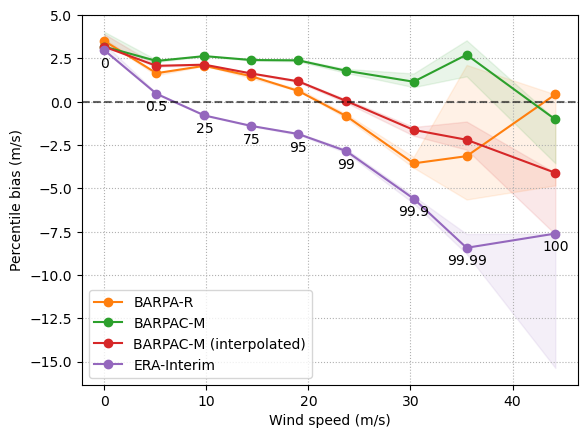

In [11]:
#This visualises the above table

t2 = int(values_obs.shape[0] * 0.05)
quants = [0,0.5,25,75,95,99,99.9,99.99,100]#np.linspace(95,100,t2)
cols = ["tab:orange","tab:green","tab:red","tab:purple"]
labels = ["BARPA-R","BARPAC-M","BARPAC-M (interpolated)","ERA-Interim"]

obs_quant = np.percentile(values_obs,quants)
for mod,c,lab in tqdm.tqdm(zip([values_12km,values_2p2km,values_2p2km_interp,values_erai],cols,labels)):


    y = np.percentile(mod,quants) - obs_quant
    me = np.mean(y)
    
    plt.fill_between(obs_quant,
                     np.percentile(np.stack([np.percentile(mod[np.random.randint(0,len(mod),len(mod))],quants) for N in np.arange(1000)]),2.5,axis=0) - obs_quant,
                     np.percentile(np.stack([np.percentile(mod[np.random.randint(0,len(mod),len(mod))],quants) for N in np.arange(1000)]),97.5,axis=0) - obs_quant,color=c,alpha=0.1)
    
    plt.plot(obs_quant, y, c=c, marker="o",label=lab)
    
    if c=="tab:purple":
        [plt.text(obs,mod-1,str(q),ha="center") for q,obs,mod in zip(quants,obs_quant,y)]    
    
plt.gca().grid(ls=":")
plt.gca().axhline(0,color="k",ls="--",alpha=0.6)
plt.ylabel("Percentile bias (m/s)")
plt.xlabel("Wind speed (m/s)")
plt.legend()

plt.savefig("/g/data/eg3/ab4502/figs/barpa/bias.jpeg",dpi=400,bbox_inches="tight")

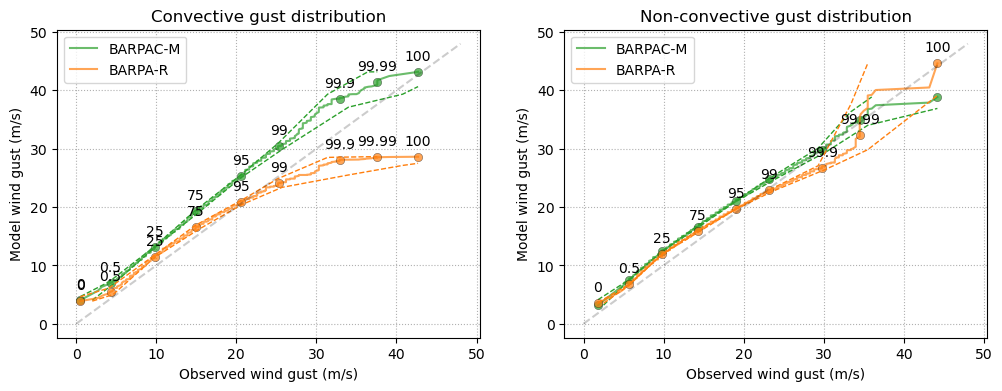

In [47]:
#Show qq-plots separately for convective and non convective gusts from BARPAC-M and BARPA-R

values_2p2km = dmax_2p2km_all.query("wgr_2p2km_point>=1.5")["wg10_2p2km_point"].values
values_12km = dmax_12km_all.query("wgr_12km_point>=1.5")["wg10_12km_point"].values
values_obs = dmax_obs_all.query("wgr_4>=1.5")["gust"].dropna().values

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)

N=1000
p = 1000; p2 = int(values_obs.shape[0] * 0.05)
quants = np.array(list(np.linspace(0,95,p)) + list(np.linspace(95,100,p2)))
quant_labels = [0,0.5,25,75,95,99,99.9,99.99,100]#p=values_obs.shape[0]
plt.plot(np.percentile(values_obs,quants),np.percentile(values_2p2km,quants),ls="-",marker="none",mec="k",mew=0.3,alpha=0.7,color="tab:green",label="BARPAC-M")
plt.plot(np.percentile(values_obs,quant_labels),np.percentile(values_2p2km,quant_labels),ls="none",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:green")
[plt.text(np.percentile(values_obs,q),np.percentile(values_2p2km,q)+2,str(q),ha="center") for q in quant_labels]
#mod_resamp = [np.percentile(values_2p2km[np.random.randint(0,len(values_2p2km),len(values_2p2km))],quant_labels) for N in np.arange(N)]
#plt.fill_between(np.percentile(values_obs,quant_labels),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:green",alpha=0.3)
obs_resamp, mod_resamp = resample(values_obs, values_2p2km, quant_labels, N)
plt.plot(obs_resamp[0],mod_resamp[1], color="tab:green",alpha=1, ls="--", lw=1)
plt.plot(obs_resamp[1],mod_resamp[0], color="tab:green",alpha=1, ls="--", lw=1)

plt.plot(np.percentile(values_obs,quants),np.percentile(values_12km,quants),ls="-",marker="none",mec="k",mew=0.3,alpha=0.7,color="tab:orange",label="BARPA-R")
plt.plot(np.percentile(values_obs,quant_labels),np.percentile(values_12km,quant_labels),ls="none",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:orange")
[plt.text(np.percentile(values_obs,q),np.percentile(values_12km,q)+2,str(q),ha="center") for q in quant_labels]
#mod_resamp = [np.percentile(values_12km[np.random.randint(0,len(values_12km),len(values_12km))],quant_labels) for N in np.arange(N)]
#plt.fill_between(np.percentile(values_obs,quant_labels),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:orange",alpha=0.3)
obs_resamp, mod_resamp = resample(values_obs, values_12km, quant_labels, N)
plt.plot(obs_resamp[0],mod_resamp[1], color="tab:orange",alpha=1, ls="--", lw=1)
plt.plot(obs_resamp[1],mod_resamp[0], color="tab:orange",alpha=1, ls="--", lw=1)

plt.plot([0,48],[0,48],color="k",ls="--",alpha=0.2)
plt.gca().grid(ls=":")
plt.legend()

plt.ylabel("Model wind gust (m/s)")
plt.xlabel("Observed wind gust (m/s)")
plt.title("Convective gust distribution")

plt.subplot(1,2,2)

values_2p2km = dmax_2p2km_all.query("wgr_2p2km_point<1.5")["wg10_2p2km_point"].values
values_12km = dmax_12km_all.query("wgr_12km_point<1.5")["wg10_12km_point"].values
values_obs = dmax_obs_all.query("wgr_4<1.5")["gust"].dropna().values

p = 1000; p2 = int(values_obs.shape[0] * 0.05)
quants = np.array(list(np.linspace(0,95,p)) + list(np.linspace(95,100,p2)))
quant_labels = [0,0.5,25,75,95,99,99.9,99.99,100]#p=values_obs.shape[0]
plt.plot(np.percentile(values_obs,quants),np.percentile(values_2p2km,quants),ls="-",marker="none",mec="k",mew=0.3,alpha=0.7,color="tab:green",label="BARPAC-M")
plt.plot(np.percentile(values_obs,quant_labels),np.percentile(values_2p2km,quant_labels),ls="none",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:green")
#mod_resamp = [np.percentile(values_2p2km[np.random.randint(0,len(values_2p2km),len(values_2p2km))],quant_labels) for N in np.arange(N)]
#plt.fill_between(np.percentile(values_obs,quant_labels),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:green",alpha=0.3)
obs_resamp, mod_resamp = resample(values_obs, values_2p2km, quant_labels, N)
plt.plot(obs_resamp[0],mod_resamp[1], color="tab:green",alpha=1, ls="--", lw=1)
plt.plot(obs_resamp[1],mod_resamp[0], color="tab:green",alpha=1, ls="--", lw=1)

plt.plot(np.percentile(values_obs,quants),np.percentile(values_12km,quants),ls="-",marker="none",mec="k",mew=0.3,alpha=0.7,color="tab:orange",label="BARPA-R")
plt.plot(np.percentile(values_obs,quant_labels),np.percentile(values_12km,quant_labels),ls="none",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:orange")
[plt.text(np.percentile(values_obs,q),np.percentile(values_12km,q)+2,str(q),ha="center") for q in quant_labels]
#mod_resamp = [np.percentile(values_12km[np.random.randint(0,len(values_12km),len(values_12km))],quant_labels) for N in np.arange(N)]
#plt.fill_between(np.percentile(values_obs,quant_labels),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:orange",alpha=0.3)
obs_resamp, mod_resamp = resample(values_obs, values_12km, quant_labels, N)
plt.plot(obs_resamp[0],mod_resamp[1], color="tab:orange",alpha=1, ls="--", lw=1)
plt.plot(obs_resamp[1],mod_resamp[0], color="tab:orange",alpha=1, ls="--", lw=1)

plt.gca().grid(ls=":")
plt.plot([0,48],[0,48],color="k",ls="--",alpha=0.2)

plt.ylabel("Model wind gust (m/s)")
plt.xlabel("Observed wind gust (m/s)")
plt.title("Non-convective gust distribution")
plt.legend()

plt.savefig("/g/data/eg3/ab4502/figs/barpa/convective_qq.jpeg",dpi=400,bbox_inches="tight")

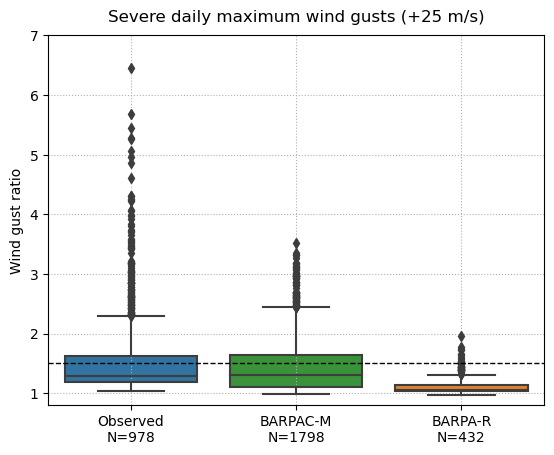

In [13]:
#Plot the distribution of wind gust ratio for observations, BARPAC-M and BARPA-R, for severe gusts only

sns.boxplot([dmax_obs_all.query("gust>=25")["wgr_4"].values,
             dmax_2p2km_all.query("wg10_2p2km_point>=25")["wgr_2p2km_point"].values, 
             dmax_12km_all.query("wg10_12km_point>=25")["wgr_12km_point"].values],palette=["tab:blue","tab:green","tab:orange"])
plt.gca().grid(ls=":")
plt.gca().axhline(1.5,color="k",ls="--",lw=1)
plt.xticks([0,1,2],["Observed\nN="+str(dmax_obs_all.query("gust>=25").shape[0]),
                    "BARPAC-M\nN="+str(dmax_2p2km_all.query("wg10_2p2km_point>=25").shape[0]),
                    "BARPA-R\nN="+str(dmax_12km_all.query("wg10_12km_point>=25").shape[0])])
plt.ylabel("Wind gust ratio")
plt.ylim([0.8,7])

plt.title("Severe daily maximum wind gusts (+25 m/s)",pad=10)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/wgr2.jpeg",dpi=400,bbox_inches="tight")

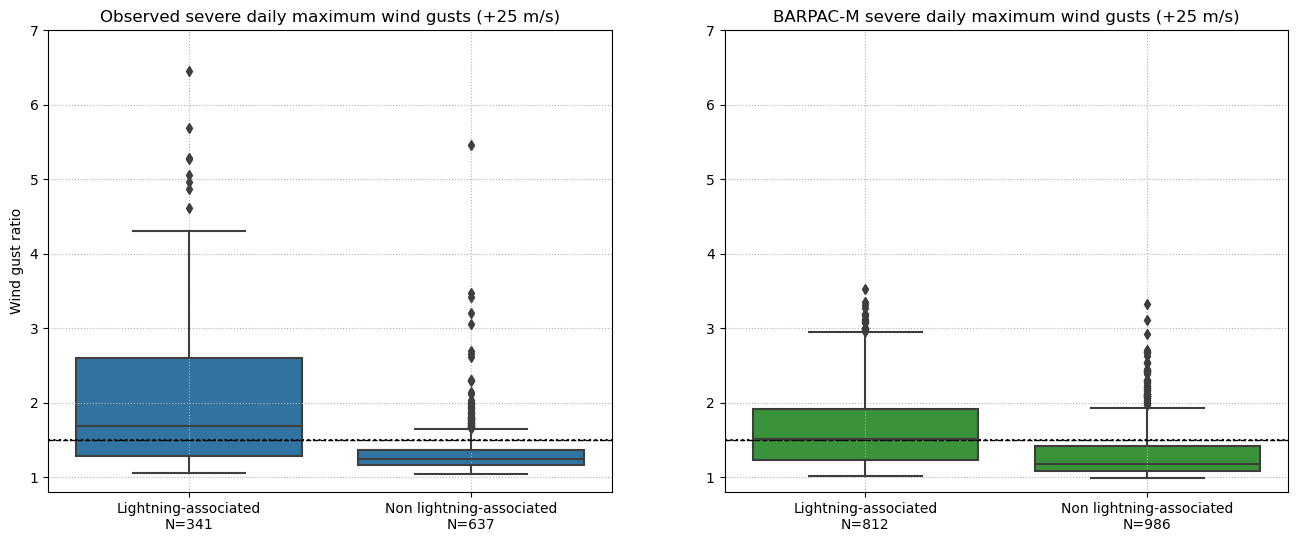

In [14]:
#Plot the distribution of wind gust ratios for lightning-associated gusts and non lightning-associated gusts, as a justification for the use of a 1.5 threshold

plt.figure(figsize=[16,6])

plt.subplot(1,2,1)
sns.boxplot([dmax_obs_all.query("(gust>=25) & (Lightning_observed_daily>=1)")["wgr_4"].values,
             dmax_obs_all.query("(gust>=25) & (Lightning_observed_daily==0)")["wgr_4"].values],palette=["tab:blue","tab:blue"])
plt.gca().axhline(1.5,color="k",ls=":")
plt.ylim([0.8,7])
plt.gca().grid(ls=":")
plt.gca().axhline(1.5,color="k",ls="--",lw=1)
plt.ylabel("Wind gust ratio")
plt.title("Observed severe daily maximum wind gusts (+25 m/s)")
plt.xticks([0,1],
           ["Lightning-associated\nN="+str(dmax_obs_all.query("(gust>=25) & (Lightning_observed_daily>=1)").shape[0]),
           "Non lightning-associated\nN="+str(dmax_obs_all.query("(gust>=25) & (Lightning_observed_daily==0)").shape[0])])

plt.subplot(1,2,2)
sns.boxplot([dmax_2p2km_all.query("(wg10_2p2km_point>=25) & (n_lightning_fl>=1)")["wgr_2p2km_point"].values,
             dmax_2p2km_all.query("(wg10_2p2km_point>=25) & (n_lightning_fl==0)")["wgr_2p2km_point"].values],palette=["tab:green","tab:green"])
plt.gca().axhline(1.5,color="k",ls=":")
plt.ylim([0.8,7])
plt.gca().grid(ls=":")
plt.gca().axhline(1.5,color="k",ls="--",lw=1)
plt.title("BARPAC-M severe daily maximum wind gusts (+25 m/s)") 
plt.xticks([0,1],
           ["Lightning-associated\nN="+str(dmax_2p2km_all.query("(wg10_2p2km_point>=25) & (n_lightning_fl>=1)").shape[0]),
           "Non lightning-associated\nN="+str(dmax_2p2km_all.query("(wg10_2p2km_point>=25) & (n_lightning_fl==0)").shape[0])])

plt.savefig("/g/data/eg3/ab4502/figs/barpa/wgr3.jpeg",dpi=400,bbox_inches="tight")

In [15]:
#Check the proportion of all severe gusts that exceed this threshols
print(dmax_obs_all.query("(gust>=25) & (wgr_4>=1.5)").shape[0] / dmax_obs_all.query("gust>=25").shape[0] * 100)
print(dmax_2p2km_all.query("(wg10_2p2km_point>=25) & (wgr_2p2km_point>=1.5)").shape[0] / dmax_2p2km_all.query("wg10_2p2km_point>=25").shape[0] * 100)
print(dmax_12km_all.query("(wg10_12km_point>=25) & (wgr_12km_point>=1.5)").shape[0] / dmax_12km_all.query("wg10_12km_point>=25").shape[0] * 100)

30.572597137014313
34.14905450500556
3.009259259259259


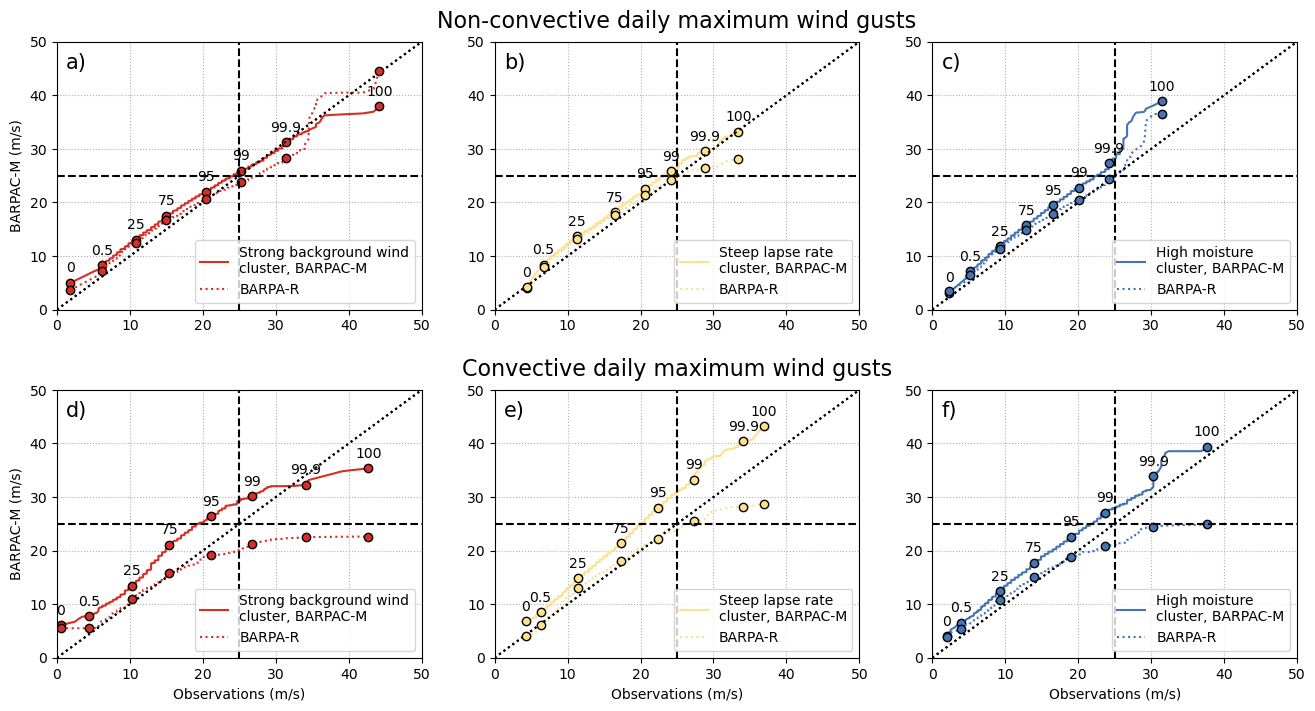

In [19]:
#Cluster-wise qq plots for convective and non-convective gusts

def plot_qq(df1,col1,df2,col2,label="",p=1000,color="tab:blue",alpha=1,plot_labels=False,ls="-"):

    p = 1000; p2 = int(values_obs.shape[0] * 0.05)
    quants = np.array(list(np.linspace(0,95,p)) + list(np.linspace(95,100,p2)))
    quant_labels = [0,0.5,25,75,95,99,99.9,100]
    
    values1 = df1[col1].values
    values2 = df2[col2].values
    #Plot all quantiles (1000 evently spaced up to 95th percentile, and then the number of quanitles is equal to 5% of the samples)
    plt.plot(np.percentile(values1,quants),np.percentile(values2,quants),label=label,marker="none",color=color,mec="k",mew=0.2,alpha=alpha,ls=ls)
    plt.legend(loc=4)    
    #Plot diagonal line
    plt.plot([0,50],[0,50],color="k",ls=":")
    #Plot the quantile label circles
    plt.plot(np.percentile(values1,quant_labels),np.percentile(values2,quant_labels),marker="o",color=color,mec="k",mew=1,alpha=alpha,ls="none")
    #Plot the quantile labels
    if plot_labels:
        [plt.text(np.percentile(values1,q),np.percentile(values2,q)+2,str(q),ha="center") for q in quant_labels]    
    plt.gca().grid(ls=":")
    

plt.figure(figsize=[16,8])

plt.subplot(2,3,1)
plot_qq(dmax_obs_nonconv.query("cluster_era5==1"),"gust",
        dmax_2p2km_nonconv.query("cluster==1"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.1),label="Strong background wind\ncluster, BARPAC-M",plot_labels=True)
plot_qq(dmax_obs_nonconv.query("cluster_era5==1"),"gust",
        dmax_12km_nonconv.query("cluster==1"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.1),label="BARPA-R",alpha=1,ls=":")
plt.ylabel("BARPAC-M (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.text(0.025,0.90,"a)",transform=plt.gca().transAxes,size=15)
plt.ylim([0,50]); plt.xlim([0,50])

plt.subplot(2,3,2)
plot_qq(dmax_obs_nonconv.query("cluster_era5==2"),"gust",
        dmax_2p2km_nonconv.query("cluster==2"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.4),label="Steep lapse rate\ncluster, BARPAC-M",plot_labels=True)

plot_qq(dmax_obs_nonconv.query("cluster_era5==2"),"gust",
        dmax_12km_nonconv.query("cluster==2"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.4),label="BARPA-R",alpha=1,ls=":")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.title("Non-convective daily maximum wind gusts",pad=10,size=16)
plt.text(0.025,0.90,"b)",transform=plt.gca().transAxes,size=15)
plt.ylim([0,50]); plt.xlim([0,50])

plt.subplot(2,3,3)
plot_qq(dmax_obs_nonconv.query("cluster_era5==0"),"gust",
        dmax_2p2km_nonconv.query("cluster==0"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.9),label="High moisture\ncluster, BARPAC-M",plot_labels=True)
plot_qq(dmax_obs_nonconv.query("cluster_era5==0"),"gust",
        dmax_12km_nonconv.query("cluster==0"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.9),label="BARPA-R",alpha=1,ls=":")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.text(0.025,0.90,"c)",transform=plt.gca().transAxes,size=15)
plt.ylim([0,50]); plt.xlim([0,50])

plt.subplot(2,3,4)
plot_qq(dmax_obs_conv.query("cluster_era5==1"),"gust",
        dmax_2p2km_conv.query("cluster==1"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.1),label="Strong background wind\ncluster, BARPAC-M",plot_labels=True)
plot_qq(dmax_obs_conv.query("cluster_era5==1"),"gust",
        dmax_12km_conv.query("cluster==1"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.1),label="BARPA-R",alpha=1,ls=":")
plt.xlabel("Observations (m/s)")
plt.ylabel("BARPAC-M (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.text(0.025,0.90,"d)",transform=plt.gca().transAxes,size=15)
plt.ylim([0,50]); plt.xlim([0,50])

plt.subplot(2,3,5)
plot_qq(dmax_obs_conv.query("cluster_era5==2"),"gust",
        dmax_2p2km_conv.query("cluster==2"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.4),label="Steep lapse rate\ncluster, BARPAC-M",plot_labels=True)
plot_qq(dmax_obs_conv.query("cluster_era5==2"),"gust",
        dmax_12km_conv.query("cluster==2"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.4),label="BARPA-R",alpha=1,ls=":")
plt.xlabel("Observations (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.title("Convective daily maximum wind gusts",pad=10,size=16)
plt.text(0.025,0.90,"e)",transform=plt.gca().transAxes,size=15)
plt.ylim([0,50]); plt.xlim([0,50])

plt.subplot(2,3,6)
plot_qq(dmax_obs_conv.query("cluster_era5==0"),"gust",
        dmax_2p2km_conv.query("cluster==0"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.9),label="High moisture\ncluster, BARPAC-M",plot_labels=True)
plot_qq(dmax_obs_conv.query("cluster_era5==0"),"gust",
        dmax_12km_conv.query("cluster==0"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.9),label="BARPA-R",alpha=1,ls=":")
plt.xlabel("Observations (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.text(0.025,0.90,"f)",transform=plt.gca().transAxes,size=15)
plt.ylim([0,50]); plt.xlim([0,50])

plt.subplots_adjust(hspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/cluster_qq.jpeg",dpi=400,bbox_inches="tight")

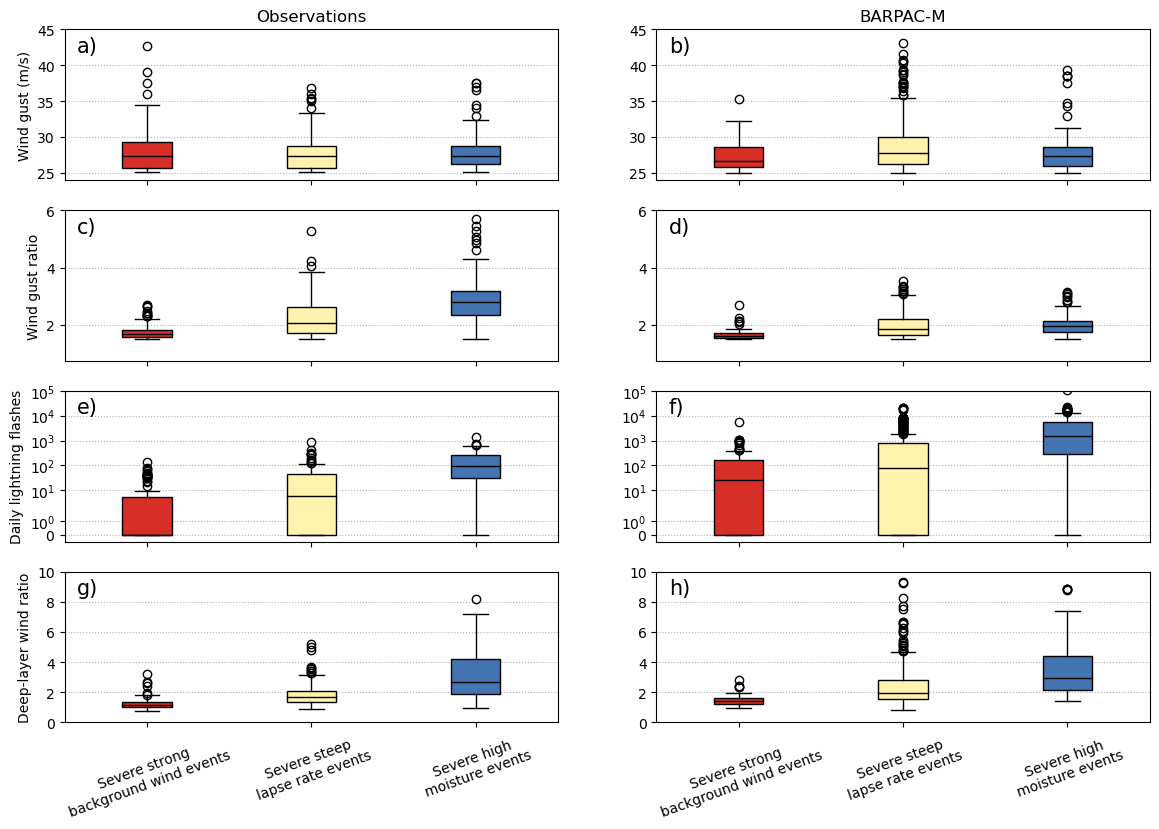

In [31]:
#Cluster statistics for SCWs

def plot_box(df_conv,v,gust_col,letter,xticks=False):
    rgb = [[0.8,0.8,0.8]]
    #p=rgb + [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]    
    p=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]    
    
    try:
        b = plt.gca().boxplot([#df_conv[df_conv[gust_col]<25][v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster_era5==1)")[v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster_era5==2)")[v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster_era5==0)")[v]],patch_artist=True);
    except:    
        b = plt.gca().boxplot([#df_conv[df_conv[gust_col]<25][v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster==1)")[v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster==2)")[v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster==0)")[v]],patch_artist=True);        

    for patch, color in zip(b["boxes"], p):
        patch.set(facecolor=color)
    [patch.set(color="k") for patch in b["medians"]]
    
    plt.gca().grid(axis="y",ls=":")
    plt.text(0.025,0.85,letter,transform=plt.gca().transAxes,size=15)
    
    if xticks:
        #plt.xticks([1,2,3,4],["Non-severe convective events","Severe strong background wind events","Severe steep lapse rate events","Severe high moisture events"])
        plt.xticks([1,2,3],["Severe strong\nbackground wind events","Severe steep\nlapse rate events","Severe high\nmoisture events"])
        plt.gca().tick_params("x",rotation=20)
    else:
        #plt.xticks([1,2,3,4],["","","",""])
        plt.xticks([1,2,3],["","",""])


plt.figure(figsize=[14,9])
plt.subplot(4,2,1); plot_box(dmax_obs_conv,"gust","gust","a)");plt.ylim([24,45]); plt.ylabel("Wind gust (m/s)"); plt.title("Observations")
plt.subplot(4,2,3); plot_box(dmax_obs_conv,"wgr_4","gust","c)");plt.ylim([0.75,6]); plt.ylabel("Wind gust ratio")
plt.subplot(4,2,5); plot_box(dmax_obs_conv,"Lightning_observed_daily","gust","e)"); plt.yscale("symlog"); plt.ylim([-0.5,1e5]); plt.ylabel("Daily lightning flashes")
plt.subplot(4,2,7); plot_box(dmax_obs_conv,"dlm_ratio","gust","g)",xticks=True); plt.ylim([0,10]); plt.ylabel("Deep-layer wind ratio")

# plt.subplot(3,3,4); plot_box(dmax_12km_conv,"wg10_12km_point","wg10_12km_point");plt.ylim([5,45])
# plt.subplot(3,3,5); plot_box(dmax_12km_conv,"wgr_12km_point","wg10_12km_point");plt.ylim([1,6])
# plt.subplot(3,3,6); plot_box(dmax_12km_conv,"n_lightning_fl","wg10_12km_point"); plt.yscale("symlog"); plt.ylim([0,1e5])

plt.subplot(4,2,2); plot_box(dmax_2p2km_conv,"wg10_2p2km_point","wg10_2p2km_point","b)");plt.ylim([24,45]); plt.title("BARPAC-M")
plt.subplot(4,2,4); plot_box(dmax_2p2km_conv,"wgr_2p2km_point","wg10_2p2km_point","d)");plt.ylim([0.75,6])
plt.subplot(4,2,6); plot_box(dmax_2p2km_conv,"n_lightning_fl","wg10_2p2km_point","f)"); plt.yscale("symlog"); plt.ylim([-0.5,1e5])
plt.subplot(4,2,8); plot_box(dmax_2p2km_conv,"dlm_ratio","wg10_2p2km_point","h)",xticks=True); plt.ylim([0,10])

plt.savefig("/g/data/eg3/ab4502/figs/barpa/cluster_stats.jpeg",dpi=400,bbox_inches="tight")

In [32]:
def get_local_hour(events):
    
    from timezonefinder import TimezoneFinder
    tf = TimezoneFinder()  # reuse    
    
    vic = load_stn_info("vic")
    nsw = load_stn_info("nsw")
    sa = load_stn_info("sa")
    tas = load_stn_info("tas")
    stn_info = pd.concat([vic,nsw,sa,tas],axis=0)

    lons = [stn_info[stn_info["stn_no"]==s][["lon"]].values[0,0] for s in events.stn_id]
    lats = [stn_info[stn_info["stn_no"]==s][["lat"]].values[0,0] for s in events.stn_id]
    tzs = [tf.timezone_at_land(lng=lon, lat=lat) for lon,lat in zip(lons,lats)]
    hour = [pd.to_datetime(t,utc=True).tz_convert(tz).hour for t,tz in zip(events.time.values,tzs)]
    
    return hour

def get_annual_counts(df,count_df,cluster,gust_col,wgr_col,cluster_col,env=False,env_thresh=0):
    
    y1 = []
    y2 = []    
    df["time"] = pd.to_datetime(df["time"])
    count = []
    
    for y in np.arange(2005,2016):
        slices = [dt.datetime(y-1,12,1), dt.datetime(y,3,1)]
        #slices = [dt.datetime(y,1,1), dt.datetime(y,12,31,23,59)]
        
        if env:
            if cluster=="all":
                y1.append(df.loc[(df.time>=slices[0]) & (df.time<=slices[1])].query("("+gust_col+">="+str(env_thresh)+")").drop_duplicates("dt_floor_1D").shape[0])
                y2.append(df.loc[(df.time>=slices[0]) & (df.time<=slices[1])].query("("+gust_col+">="+str(env_thresh)+")").shape[0])
            else:
                y1.append(df.loc[(df.time>=slices[0]) & (df.time<=slices[1])].query("("+gust_col+">="+str(env_thresh)+") & ("+cluster_col+"=="+cluster+")").drop_duplicates("dt_floor_1D").shape[0])
                y2.append(df.loc[(df.time>=slices[0]) & (df.time<=slices[1])].query("("+gust_col+">="+str(env_thresh)+") & ("+cluster_col+"=="+cluster+")").shape[0])                  
        else:
        
            if cluster=="all":
                y1.append(df.loc[(df.time>=slices[0]) & (df.time<=slices[1])].query("("+gust_col+">=25) & ("+wgr_col+" >= 1.5)").drop_duplicates("dt_floor_1D").shape[0])
                y2.append(df.loc[(df.time>=slices[0]) & (df.time<=slices[1])].query("("+gust_col+">=25) & ("+wgr_col+" >= 1.5)").shape[0])
            else:
                y1.append(df.loc[(df.time>=slices[0]) & (df.time<=slices[1])].query("("+gust_col+">=25) & ("+wgr_col+" >= 1.5) & ("+cluster_col+"=="+cluster+")").drop_duplicates("dt_floor_1D").shape[0])
                y2.append(df.loc[(df.time>=slices[0]) & (df.time<=slices[1])].query("("+gust_col+">=25) & ("+wgr_col+" >= 1.5) & ("+cluster_col+"=="+cluster+")").shape[0])      
    
        count.append(count_df.loc[(count_df.time>=slices[0]) & (count_df.time<=slices[1])].dropna(subset=[gust_col]).shape[0])
                     
    return y1/np.array(count) , y2/np.array(count), np.array(count)
    #return y1 , y2
                     
def smooted_monthly_ts(df, gust_col, wgr_col,days=False,env=False,env_thresh=0,norm=True):
    years = np.arange(2005,2016)
    df["time"] = pd.to_datetime(df["time"])
    
    y2 = []
    m2 = []

    ycount = []
    mcount = []

    ytick = []
    mtick = []

    for y in years:
        if y == 2005:
            months = [dt.datetime(y,1,1), dt.datetime(y,2,1)]
        else:
            months = [dt.datetime(y-1,12,1), dt.datetime(y,1,1), dt.datetime(y,2,1)]
            #months = [dt.datetime(y,1,1), dt.datetime(y,2,1), dt.datetime(y,12,1)]

            
        ytick.append(dt.datetime(y,1,1))
        ycount.append(df.loc[(df.time >= months[0]) & (df.time < dt.datetime(y,3,1))].dropna(subset=[gust_col]).shape[0])
        if days:
            y2.append(df.loc[(df.time >= months[0]) & (df.time < dt.datetime(y,3,1))].query("("+gust_col+">=25) & ("+wgr_col+" >= 1.5)").drop_duplicates("dt_floor_1D").shape[0])
        else:
            y2.append(df.loc[(df.time >= months[0]) & (df.time < dt.datetime(y,3,1))].query("("+gust_col+">=25) & ("+wgr_col+" >= 1.5)").shape[0])
        
        for m in months:
            
            if env:
                    m2.append(df.loc[(df.time.dt.month==m.month) & (df.time.dt.year==m.year)][gust_col].mean())
            else:
                if days:
                    m2.append(df.loc[(df.time.dt.month==m.month) & (df.time.dt.year==m.year)].query("("+gust_col+">=25) & ("+wgr_col+" >= 1.5)").drop_duplicates("dt_floor_1D").shape[0])                
                else:
                    m2.append(df.loc[(df.time.dt.month==m.month) & (df.time.dt.year==m.year)].query("("+gust_col+">=25) & ("+wgr_col+" >= 1.5)").shape[0])
                
            mcount.append(df.loc[(df.time.dt.month==m.month) & (df.time.dt.year==m.year)].dropna(subset=[gust_col]).shape[0])
            mtick.append(m)

    mcount = np.array(mcount)
    ycount = np.array(ycount)

    m2 = np.array(m2)
    
    if norm:
        m2 = m2 / mcount
        y2 = y2 / ycount


    # for i in np.arange(len(years)):
    #     if i == 0:
    #         y2.append( (m2[i] + m2[i+1]) / 2.)
    #     else:
    #         y2.append( (m2[i*3-1] + m2[i*3] + m2[i*3+1]) / 3.)        

    return m2, y2, mtick, ytick, mcount, ycount

SignificanceResult(statistic=0.5629181583535791, pvalue=0.0007964387991449386)
SignificanceResult(statistic=0.27272727272727276, pvalue=0.41714143714253127)


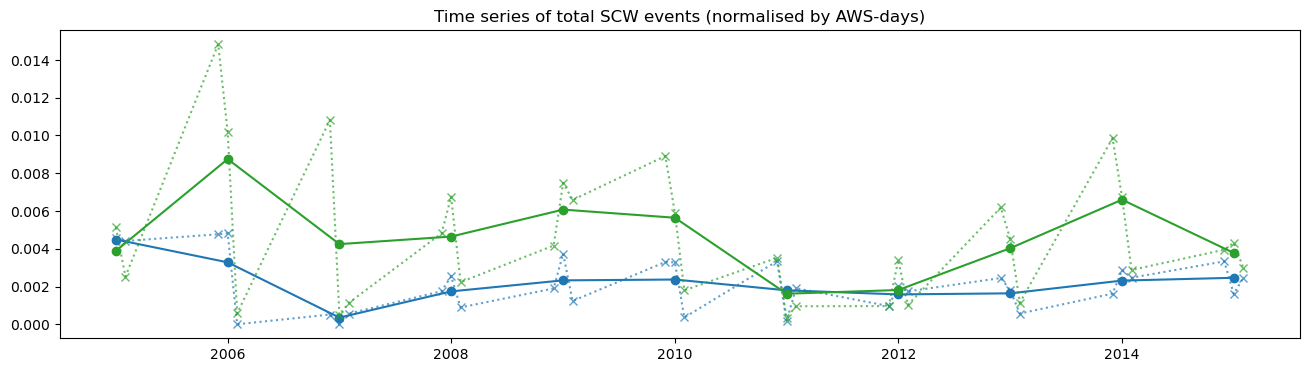

In [34]:
#Compare total number of daily max SCW events across all station locations

plt.figure(figsize=[16,4])

m1, y1, mtick, ytick, mcount, ycount = smooted_monthly_ts(dmax_obs_all, "gust", "wgr_4", days=False)
m2, y2, mtick, ytick, mcount, ycount = smooted_monthly_ts(dmax_2p2km_all, "wg10_2p2km_point", "wgr_2p2km_point", days=False)

plt.plot(mtick, m1,marker="x",ls=":",color="tab:blue",alpha=0.7)
plt.plot(ytick, y1,marker="o",color="tab:blue")

plt.plot(mtick, m2,marker="x",ls=":",color="tab:green",alpha=0.7)
plt.plot(ytick, y2,marker="o",color="tab:green")

plt.title("Time series of total SCW events (normalised by AWS-days)")

print(spearmanr(m1, m2))
print(spearmanr(y1, y2))

SignificanceResult(statistic=0.6787645523879203, pvalue=1.9522175189438975e-05)
SignificanceResult(statistic=0.5727272727272729, pvalue=0.06554305260101842)


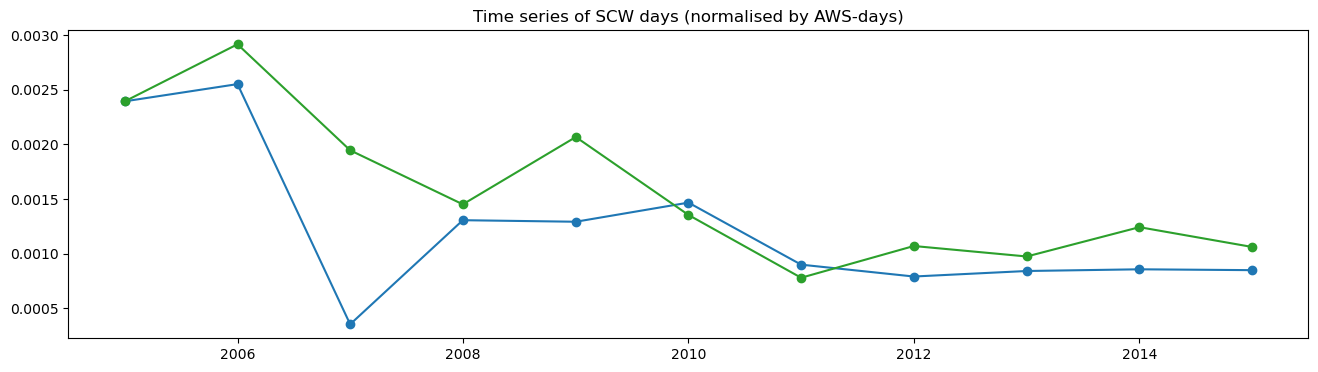

In [37]:
#Compare total number of days with at least one SCW event anywhere in the domain
plt.figure(figsize=[16,4])
m1, y1, mtick, ytick, mcount, ycount = smooted_monthly_ts(dmax_obs_all, "gust", "wgr_4", days=True)
m2, y2, mtick, ytick, mcount, ycount = smooted_monthly_ts(dmax_2p2km_all, "wg10_2p2km_point", "wgr_2p2km_point", days=True)

plt.plot(ytick, y1,marker="o",color="tab:blue")

plt.plot(ytick, y2,marker="o",color="tab:green")

plt.title("Time series of SCW days (normalised by AWS-days)")

print(spearmanr(m1, m2))
print(spearmanr(y1, y2))

Text(0, 0.5, 'Total station-days')

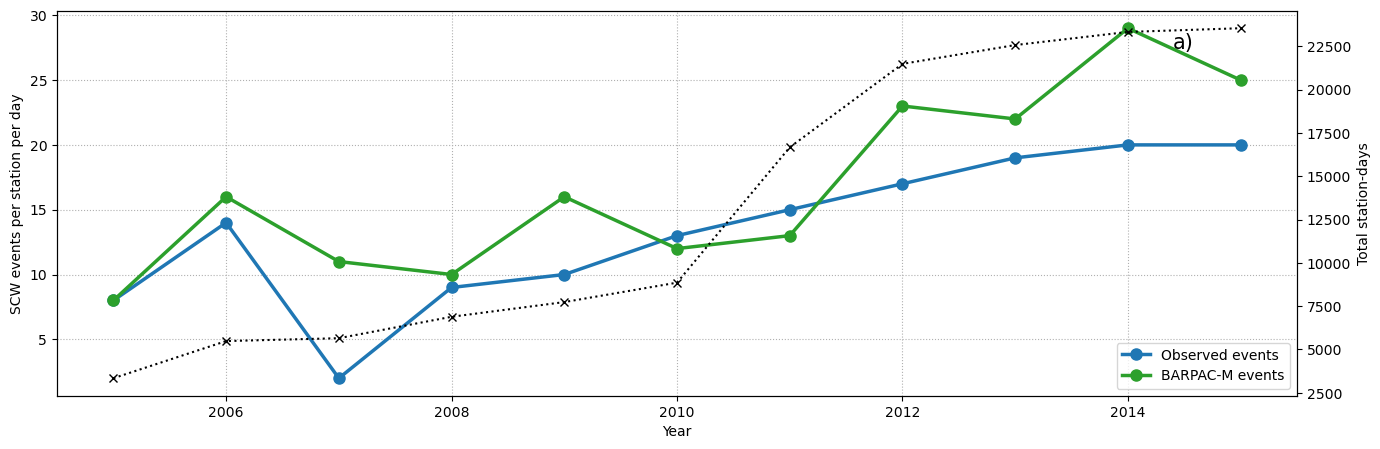

In [39]:
plt.figure(figsize=[16,5])

m1, y1, mtick, ytick, mcount, ycount = smooted_monthly_ts(dmax_obs_all, "gust", "wgr_4", days=True)
m2, y2, mtick, ytick, mcount, ycount = smooted_monthly_ts(dmax_2p2km_all, "wg10_2p2km_point", "wgr_2p2km_point", days=True)

plt.plot(np.arange(2005,2016),
         y1 * ycount,
         marker="o",label="Observed events",color="tab:blue",lw=2.5,ms=8)
plt.plot(np.arange(2005,2016),
         y2 * ycount,
         marker="o",label="BARPAC-M events",color="tab:green",lw=2.5,ms=8)
plt.gca().grid(ls=":")
plt.ylabel("SCW events per station per day")
plt.xlabel("Year")
plt.text(0.9,0.9,"a)",size=15,transform=plt.gca().transAxes)
plt.legend(loc=4)
ax2 = plt.gca().twinx()
ax2.plot(np.arange(2005,2016),ycount,color="k",ls=":",marker="x")
ax2.set_ylabel("Total station-days")


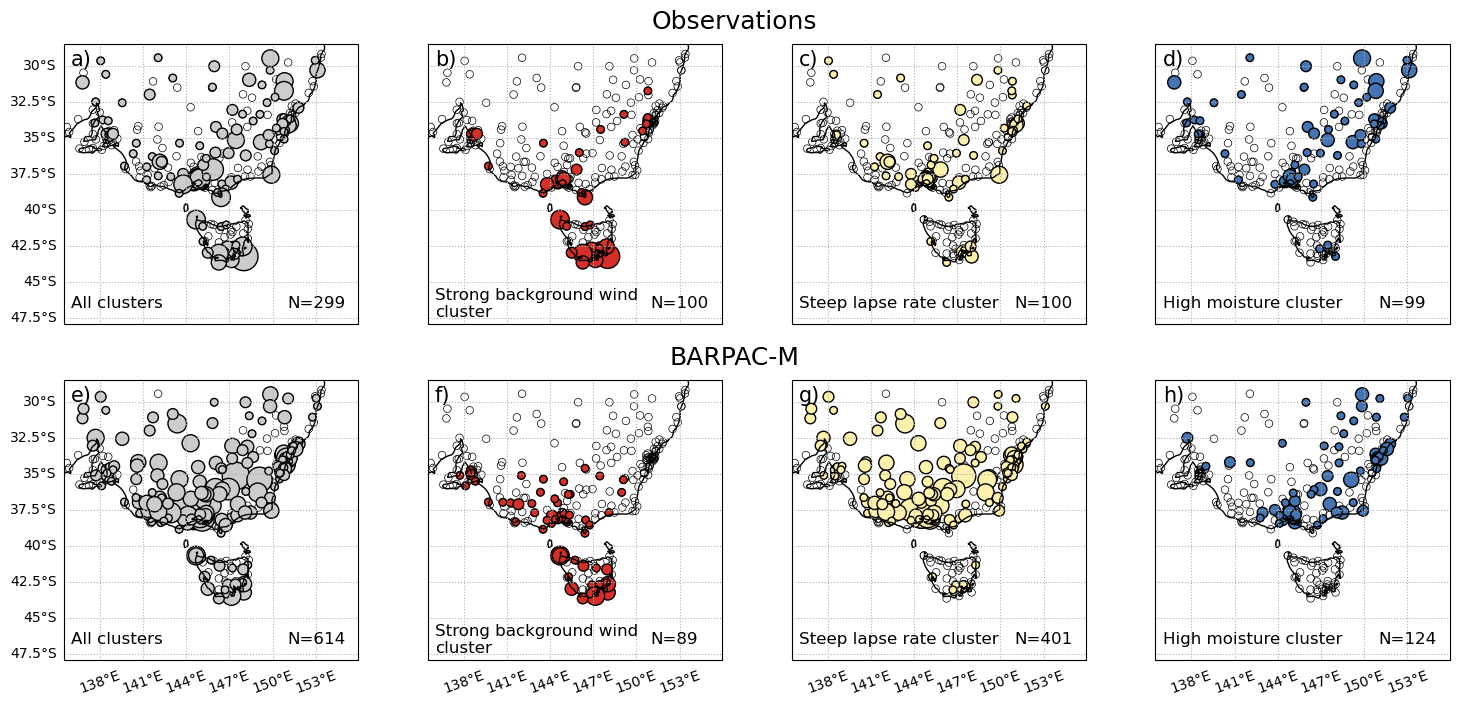

In [42]:
def plot_event_map(ax,cluster,df,data,stns,stn_info,letter,ytick=False,xtick=False):
    rgb=[[0.8,0.8,0.8]]
    p=rgb + [plt.get_cmap("RdYlBu")(i) for i in [0.9,0.1,0.46]]    

    stn_events = []
    lons = []
    lats = []    
    if cluster >= 0:
        if data=="obs":
            for stn in stns:
                stn_events.append(df[df.stn_id==stn].query("(gust>=25) & (cluster_era5=="+str(cluster)+")").shape[0])
                lons.append(stn_info[stn_info.stn_no==stn]["lon"])
                lats.append(stn_info[stn_info.stn_no==stn]["lat"])                           
        elif data=="model":
            for stn in stns:
                stn_events.append(df[df.stn_id==stn].query("(wg10_2p2km_point>=25) & (cluster=="+str(cluster)+")").shape[0])
                lons.append(stn_info[stn_info.stn_no==stn]["lon"])
                lats.append(stn_info[stn_info.stn_no==stn]["lat"])                
    else:
        if data=="obs":
            for stn in stns:
                stn_events.append(df[df.stn_id==stn].query("(gust>=25)").shape[0])
                lons.append(stn_info[stn_info.stn_no==stn]["lon"])
                lats.append(stn_info[stn_info.stn_no==stn]["lat"])            
        elif data=="model":
            for stn in stns:
                stn_events.append(df[df.stn_id==stn].query("(wg10_2p2km_point>=25)").shape[0])
                lons.append(stn_info[stn_info.stn_no==stn]["lon"])
                lats.append(stn_info[stn_info.stn_no==stn]["lat"])       

    stn_events=np.array(stn_events)
    lons=np.array(lons)    
    lats=np.array(lats)    
    size_factor=30
    #ax.scatter(lons[stn_events==0],lats[stn_events==0],marker="o",color="none",s=40,edgecolor="k",linewidths=0.5)
    ax.scatter(lons,lats,marker="o",color="none",s=size_factor,edgecolor="k",linewidths=0.5)
    ax.scatter(lons[stn_events>0],lats[stn_events>0],marker="o",color=p[cluster+1],s=stn_events[stn_events>0]*size_factor,edgecolor="k")
                            
    ax.text(151,-46.5,"N="+str(stn_events.sum()),fontdict={"size":12,"va":"center"})
    cluster_names = ["All clusters","High moisture cluster","Strong background wind\ncluster","Steep lapse rate cluster"]
    ax.text(136,-46.5,cluster_names[cluster+1],fontdict={"size":12,"va":"center"})
    
    ax.coastlines()
    ax.set_ylim(lat_lims)
    ax.set_xlim(lon_lims)
    ax.text(0.025,0.925,letter,transform=ax.transAxes,size=15)
    
    g=ax.gridlines(draw_labels=True,ylabel_style={"size":10},xlabel_style={"size":10,"rotation":20},ls=":");
    g.top_labels=False; g.right_labels=False
    if not ytick:
        g.left_labels = False
    if not xtick:
        g.bottom_labels = False
        
    return stn_events, lons, lats
    
    
vic = load_stn_info("vic")
nsw = load_stn_info("nsw")
sa = load_stn_info("sa")
tas = load_stn_info("tas")
stn_info = pd.concat([vic,nsw,sa,tas],axis=0)

f=xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/topog-BARPAC-M_km2p2.nc")
lon_lims = [f.longitude.values.min(),f.longitude.values.max()]
lat_lims = [f.latitude.values.min(),f.latitude.values.max()+0.5]    
    
    
fig=plt.figure(figsize=[18,8])

stn_events_obs, lons_obs, lats_obs =plot_event_map(plt.subplot(2,4,1,projection=ccrs.PlateCarree()), -1, dmax_obs_conv, "obs", dmax_obs_all.stn_id.unique(), stn_info, "a)", ytick=True)
stn_events_mod, lons_mod, lats_mod=plot_event_map(plt.subplot(2,4,5,projection=ccrs.PlateCarree()), -1, dmax_2p2km_conv, "model", dmax_2p2km_all.stn_id.unique(), stn_info, "e)", ytick=True, xtick=True)

plot_event_map(plt.subplot(2,4,2,projection=ccrs.PlateCarree()), 1, dmax_obs_conv, "obs", dmax_obs_all.stn_id.unique(), stn_info, "b)");
plot_event_map(plt.subplot(2,4,6,projection=ccrs.PlateCarree()), 1, dmax_2p2km_conv, "model", dmax_2p2km_all.stn_id.unique(), stn_info, "f)", xtick=True);

stn_events_obs2, lons_obs, lats_obs = plot_event_map(plt.subplot(2,4,3,projection=ccrs.PlateCarree()), 2, dmax_obs_conv, "obs", dmax_obs_all.stn_id.unique(), stn_info, "c)");
stn_events_mod2, lons_mod, lats_mod = plot_event_map(plt.subplot(2,4,7,projection=ccrs.PlateCarree()), 2, dmax_2p2km_conv, "model", dmax_2p2km_all.stn_id.unique(), stn_info, "g)", xtick=True);

plot_event_map(plt.subplot(2,4,4,projection=ccrs.PlateCarree()), 0, dmax_obs_conv, "obs", dmax_obs_all.stn_id.unique(), stn_info, "d)");
plot_event_map(plt.subplot(2,4,8,projection=ccrs.PlateCarree()), 0, dmax_2p2km_conv, "model", dmax_2p2km_all.stn_id.unique(), stn_info, "h)", xtick=True);

plt.text(0.5,0.9,"Observations",transform=fig.transFigure,size=18,ha="center")
plt.text(0.5,0.48,"BARPAC-M",transform=fig.transFigure,size=18,ha="center")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/cluster_map.jpeg",dpi=400,bbox_inches="tight")

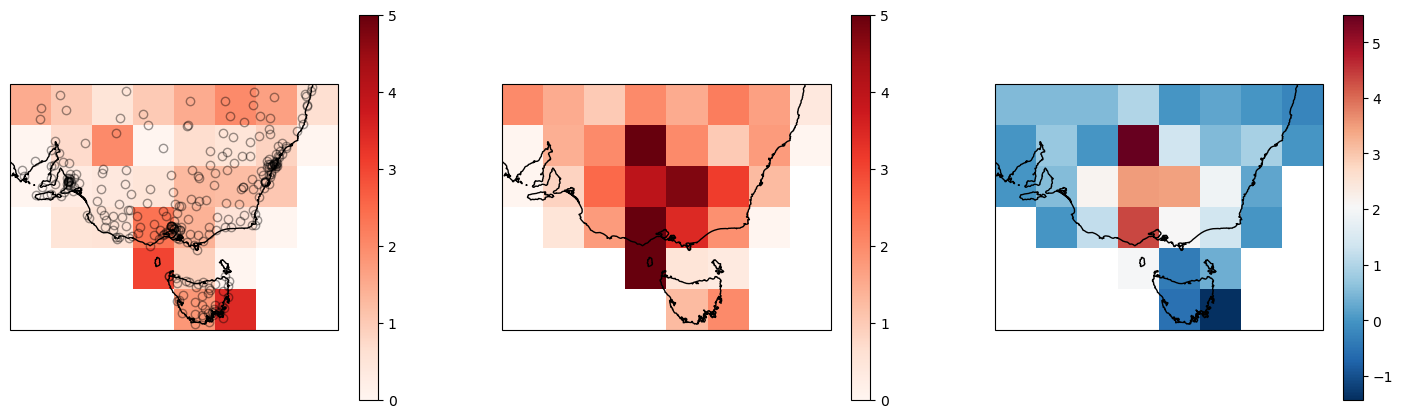

In [43]:
lons_obs = lons_obs.squeeze()
lats_obs = lats_obs.squeeze()

lons_int = np.arange(135, 155 + 2.5, 2.5)
lats_int = np.arange(-44, -30 + 2.5, 2.5)

lons_int, lats_int = np.meshgrid(lons_int, lats_int)

out_obs = np.zeros((lons_int.shape[0]-1, lons_int.shape[1]-1))
for i in np.arange(out_obs.shape[0]):
    for j in np.arange(out_obs.shape[1]):
        if ((lons_obs >= lons_int[i,j]) & (lons_obs <= lons_int[i,j+1]) & (lats_obs >= lats_int[i,j]) & (lats_obs <= lats_int[i+1,j])).max() == 1:
            out_obs[i,j] = (np.mean(stn_events_obs[(lons_obs >= lons_int[i,j]) & (lons_obs <= lons_int[i,j+1]) & (lats_obs >= lats_int[i,j]) & (lats_obs <= lats_int[i+1,j])]))
        else:
            out_obs[i,j] = np.nan
            
lons_mod = lons_mod.squeeze()
lats_mod = lats_mod.squeeze()

out_mod = np.zeros((lons_int.shape[0]-1, lons_int.shape[1]-1))
for i in np.arange(out_mod.shape[0]):
    for j in np.arange(out_mod.shape[1]):
        if ((lons_mod >= lons_int[i,j]) & (lons_mod <= lons_int[i,j+1]) & (lats_mod >= lats_int[i,j]) & (lats_mod <= lats_int[i+1,j])).max() == 1:
            out_mod[i,j] = (np.mean(stn_events_mod[(lons_mod >= lons_int[i,j]) & (lons_mod <= lons_int[i,j+1]) & (lats_mod >= lats_int[i,j]) & (lats_mod <= lats_int[i+1,j])]))
        else:
            out_mod[i,j] = np.nan 
            
plt.figure(figsize=[18,5])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
plt.pcolormesh(lons_int, lats_int, out_obs, cmap=plt.get_cmap("Reds"), vmin=0, vmax=5); plt.colorbar()
ax.coastlines()
ax.plot(lons_obs, lats_obs, ls="none", marker="o", color="none", mec="k", alpha=0.4)

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
plt.pcolormesh(lons_int, lats_int, out_mod, cmap=plt.get_cmap("Reds"), vmin=0, vmax=5); plt.colorbar()
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
plt.pcolormesh(lons_int, lats_int, (out_mod - out_obs), cmap=plt.get_cmap("RdBu_r")); plt.colorbar()
ax.coastlines()            

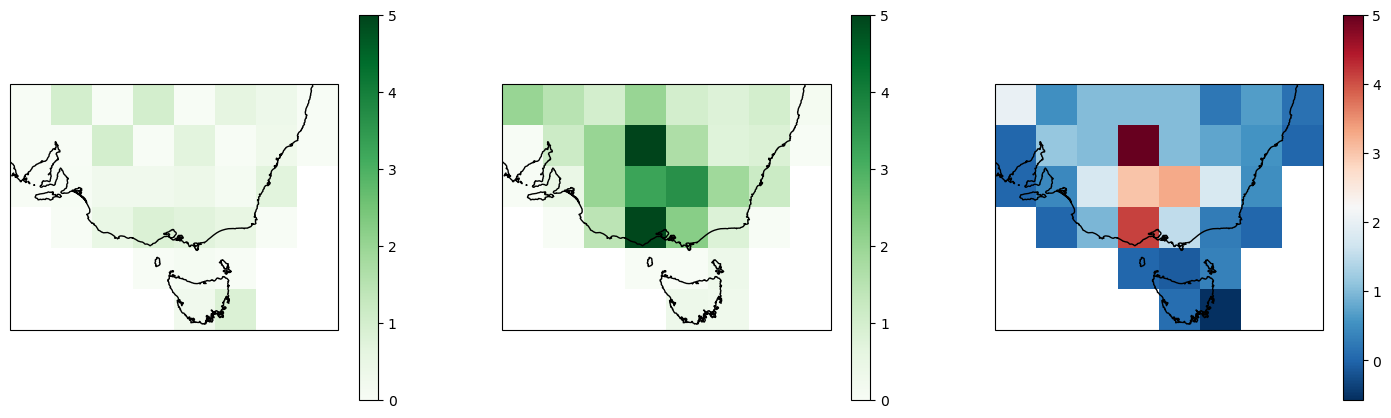

In [44]:
out_obs = np.zeros((lons_int.shape[0]-1, lons_int.shape[1]-1))
for i in np.arange(out_obs.shape[0]):
    for j in np.arange(out_obs.shape[1]):
        if ((lons_obs >= lons_int[i,j]) & (lons_obs <= lons_int[i,j+1]) & (lats_obs >= lats_int[i,j]) & (lats_obs <= lats_int[i+1,j])).max() == 1:
            out_obs[i,j] = (np.mean(stn_events_obs2[(lons_obs >= lons_int[i,j]) & (lons_obs <= lons_int[i,j+1]) & (lats_obs >= lats_int[i,j]) & (lats_obs <= lats_int[i+1,j])]))
        else:
            out_obs[i,j] = np.nan

out_mod = np.zeros((lons_int.shape[0]-1, lons_int.shape[1]-1))
for i in np.arange(out_mod.shape[0]):
    for j in np.arange(out_mod.shape[1]):
        if ((lons_mod >= lons_int[i,j]) & (lons_mod <= lons_int[i,j+1]) & (lats_mod >= lats_int[i,j]) & (lats_mod <= lats_int[i+1,j])).max() == 1:
            out_mod[i,j] = (np.mean(stn_events_mod2[(lons_mod >= lons_int[i,j]) & (lons_mod <= lons_int[i,j+1]) & (lats_mod >= lats_int[i,j]) & (lats_mod <= lats_int[i+1,j])]))
        else:
            out_mod[i,j] = np.nan 
            
plt.figure(figsize=[18,5])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
plt.pcolormesh(lons_int, lats_int, out_obs, cmap=plt.get_cmap("Greens"), vmin=0, vmax=5); plt.colorbar()
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
plt.pcolormesh(lons_int, lats_int, out_mod, cmap=plt.get_cmap("Greens"), vmin=0, vmax=5); plt.colorbar()
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
plt.pcolormesh(lons_int, lats_int, (out_mod - out_obs), cmap=plt.get_cmap("RdBu_r")); plt.colorbar()
ax.coastlines()            